# Data Pre-processing

In [159]:
import pandas as pd
import chardet

def read_csv_file(file_path):
    with open(file_path, 'rb') as f:
        result = chardet.detect(f.read())
    data_df = pd.read_csv(file_path, encoding=result['encoding'])
    return data_df

file_path = r"data_df_houseP_new.csv"
data_df = read_csv_file(file_path)

In [160]:
file_path_r = r"RN_extra_imd_vars.csv"
data_df_r = read_csv_file(file_path_r)

In [161]:
data_df['median_IMD_Rank'] = data_df_r['median_IMD_Rank']

In [162]:
data_df

,Account Number/Reference,Member Number (Account Holder) (Person),Product,Product Code (Product) (Product),Account Balance,Available Account Balance,Loan Granted,Repayment Amount,Repayment Frequency,Arrears Value,...,WorstPaymentStatusAtApplication,Mortgage,Postcode,Loan Offer Interest Rate,Current Interest Rate,loan_number,previously_bad_loan,previously_good_loan,House price,median_IMD_Rank
0,0103xxx9,1812972,Personal Loan,PLN1,0.00,0.00,2022-12-31,21.68,Weekly,0.0,...,D,False,BS4 1,36.00,36.00,2,False,True,285570.000000,2467.0
1,0103xxx8,2393616,Personal Loan,PLN1,-2.65,0.00,2022-12-31,287.87,Monthly,0.0,...,U,False,BS9 2,28.82,28.82,3,False,False,573081.250000,19881.0
2,0103xxx6,3764700,Personal Loan,PLN1,0.00,0.00,2022-12-31,44.31,Weekly,0.0,...,U,False,BS10 5,28.82,28.82,1,False,False,365593.750000,9429.0
3,0103xxx4,3781776,Personal Loan,PLN1,0.00,0.00,2022-12-31,52.76,Monthly,0.0,...,D,False,BA14 8,36.00,36.00,1,False,False,252257.500000,14932.0
4,0103xxx3,2377560,Personal Loan,PLN1,-2.12,0.00,2022-12-30,27.65,Weekly,0.0,...,D,False,BS13 8,36.00,36.00,2,False,False,316465.909091,4064.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,0102xxx3,3636456,Personal Loan,PLN1,0.00,0.00,2022-01-04,38.92,Weekly,0.0,...,No match,No match,NO MATCH,28.82,28.82,1,False,False,NaN,NaN
5231,0102xxx2,2081220,Personal Loan,PLN1,0.00,0.00,2022-01-04,86.81,Monthly,0.0,...,No match,No match,NO MATCH,36.00,36.00,1,False,False,NaN,NaN
5232,0102xxx0,3687432,Family Finance Plan,FFP,0.00,0.01,2022-01-04,11.50,Weekly,0.0,...,No match,No match,NO MATCH,36.00,36.00,1,False,False,NaN,NaN
5233,0102xxx8,3687336,Personal Loan,PLN1,0.00,0.00,2022-01-04,255.67,Monthly,0.0,...,No match,No match,NO MATCH,10.43,10.43,1,False,False,NaN,NaN


In [163]:
import pandas as pd
import numpy as np
import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Replace "No match" with np.nan
data_df.replace(["No match", "Check me","Check"], np.nan, inplace=True)
    
# Delete rows containing null or empty values
data_df.dropna(inplace=True)

# Drop 3rd Party Rating 
data_df = data_df.drop(columns=['Nestegg score', 'NesteggScoreBand', 'NestEgg-mini-band', 'Nestegg autodecision'])
# Drop Unknown at Application
data_df = data_df.drop(columns=['Interest Paid Date', 'Status', 'CurrentStatus', 'BD Balance check', 'FinalBalance', 'Member Status (Account Holder) (Person)', 'AmIDebtCon', 'Current Interest Rate', 'Arrears Value'])
# Drop Irrelevant Variables 
data_df = data_df.drop(columns=['Account Number/Reference','Member Number (Account Holder) (Person)','Loan Granted','Originating Application', 'LoanNo', 'Product Code (Product) (Product)', 'Month issued', 'Banding', 'Postcode'])

In [164]:
# Changing the values of 'Banding' to the first letter
data_df['PLN Value Band'] = data_df['PLN Value Band'].apply(lambda x: x[0])

In [165]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

## These variables are binary, therefore LabelEncoder is appropriate and no dummary variable trap is introduced
categorical_features = ['GoodBadStatus', 'ExistingMemberApp', 'AmIDebtCon', 
                        'DefaultsAtApplication', 'CCJsAtApplication', 'Mortgage']

le = LabelEncoder()

for col in categorical_features:
    if col in data_df.columns:
        data_df[col] = le.fit_transform(data_df[col])


In [166]:
## These variables are non-binary so require dummy variable handling
dummy_features = ['Product', 'Repayment Method']

# Apply one-hot encoding and drop first variables
data_df = pd.get_dummies(data_df, columns=dummy_features, drop_first=True)

print(data_df)

      Account Balance  Available Account Balance  Repayment Amount  \
0                0.00                        0.0             21.68   
1               -2.65                        0.0            287.87   
2                0.00                        0.0             44.31   
3                0.00                        0.0             52.76   
4               -2.12                        0.0             27.65   
...               ...                        ...               ...   
5206             0.00                        0.0             20.55   
5210             0.00                        0.0             75.11   
5213             0.00                        0.0             12.40   
5215             0.00                        0.0            113.59   
5217             0.00                        0.0            110.98   

     Repayment Frequency  Repayment Term Amount issued  GoodBadStatus  \
0                 Weekly             100       1555.85              1   
1            

In [167]:
def scale_to_daily(amount, frequency):
    if frequency == 'Weekly':
        return amount / 7
    elif frequency == 'Fortnightly':
        return amount / 14
    elif frequency == 'Four Weekly':
        return amount / 28
    elif frequency == 'Monthly':
        return amount / 30
    else:
        return None

# Apply the function to create 'Repayment Amount (daily)' and drop 'Repayment Amount'
data_df['Repayment Amount (daily)'] = data_df.apply(lambda row: scale_to_daily(row['Repayment Amount'], row['Repayment Frequency']), axis=1)
data_df = data_df.drop(columns=['Repayment Amount'])


In [168]:
data_df

,Account Balance,Available Account Balance,Repayment Frequency,Repayment Term,Amount issued,GoodBadStatus,ExistingMemberApp,PLN Value Band,MthEquivTerm,Average Debt/Income Ratio,...,Product_Employer Partner Loan,Product_Family Finance Plan,Product_Flex@Work,Product_Personal Loan,Repayment Method_Debt Management Plan,Repayment Method_Debt Relief Order,Repayment Method_Individual Voluntary Arrangement,Repayment Method_Payment Arrangement,Repayment Method_Standard,Repayment Amount (daily)
0,0.00,0.0,Weekly,100,1555.85,1,1,1,23.08,0.11891666666666667,...,False,False,False,True,False,False,False,False,True,3.097143
1,-2.65,0.0,Monthly,7,1842.35,1,1,2,7.00,0.09852380952380953,...,False,False,False,True,False,False,False,False,True,9.595667
2,0.00,0.0,Weekly,52,2000,1,0,2,12.00,0.29094444444444445,...,False,False,False,True,False,False,False,False,True,6.330000
3,0.00,0.0,Monthly,4,200,1,0,1,4.00,0.1018287037037037,...,False,False,False,True,False,False,False,False,True,1.758667
4,-2.12,0.0,Weekly,52,1200.14,1,1,1,12.00,0.02455640050697085,...,False,False,False,True,False,False,False,False,True,3.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5206,0.00,0.0,Weekly,41,730.37,1,1,1,9.46,0.11222222222222222,...,False,False,False,True,False,False,False,False,True,2.935714
5210,0.00,0.0,Monthly,12,750,0,0,1,12.00,0,...,False,False,False,True,False,False,False,False,True,2.503667
5213,0.00,0.0,Weekly,49,581.45,1,1,1,11.31,0.8944940476190476,...,False,False,False,True,False,False,False,False,True,1.771429
5215,0.00,0.0,Monthly,17,1517.91,1,1,1,17.00,0.07555555555555556,...,False,False,False,True,False,False,False,False,True,3.786333


In [169]:
print(data_df.dtypes)

Account Balance                                      float64
Available Account Balance                            float64
Repayment Frequency                                   object
Repayment Term                                         int64
Amount issued                                         object
GoodBadStatus                                          int32
ExistingMemberApp                                      int32
PLN Value Band                                        object
MthEquivTerm                                         float64
Average Debt/Income Ratio                             object
Age when loan created (years)                          int64
Length of membership when loan created (months)        int64
StatedTotalIncome                                     object
TotalDebtOutstandingApplication                       object
DefaultsAtApplication                                  int32
CCJsAtApplication                                      int32
WorstPaymentStatusAtAppl

In [170]:
###### Manage variables 'previously_bad_loan' and 'previously_good_loan' ###########
# Convert columns to string type explicitly
data_df['previously_bad_loan'] = data_df['previously_bad_loan'].astype(str)
data_df['previously_good_loan'] = data_df['previously_good_loan'].astype(str)

# Strip any leading/trailing whitespace and convert to lowercase
data_df['previously_bad_loan'] = data_df['previously_bad_loan'].str.strip().str.lower()
data_df['previously_good_loan'] = data_df['previously_good_loan'].str.strip().str.lower()

# Convert 'false' and 'true' strings to boolean False and True
data_df['previously_bad_loan'] = data_df['previously_bad_loan'].map({'false': False, 'true': True})
data_df['previously_good_loan'] = data_df['previously_good_loan'].map({'false': False, 'true': True})

data_df

,Account Balance,Available Account Balance,Repayment Frequency,Repayment Term,Amount issued,GoodBadStatus,ExistingMemberApp,PLN Value Band,MthEquivTerm,Average Debt/Income Ratio,...,Product_Employer Partner Loan,Product_Family Finance Plan,Product_Flex@Work,Product_Personal Loan,Repayment Method_Debt Management Plan,Repayment Method_Debt Relief Order,Repayment Method_Individual Voluntary Arrangement,Repayment Method_Payment Arrangement,Repayment Method_Standard,Repayment Amount (daily)
0,0.00,0.0,Weekly,100,1555.85,1,1,1,23.08,0.11891666666666667,...,False,False,False,True,False,False,False,False,True,3.097143
1,-2.65,0.0,Monthly,7,1842.35,1,1,2,7.00,0.09852380952380953,...,False,False,False,True,False,False,False,False,True,9.595667
2,0.00,0.0,Weekly,52,2000,1,0,2,12.00,0.29094444444444445,...,False,False,False,True,False,False,False,False,True,6.330000
3,0.00,0.0,Monthly,4,200,1,0,1,4.00,0.1018287037037037,...,False,False,False,True,False,False,False,False,True,1.758667
4,-2.12,0.0,Weekly,52,1200.14,1,1,1,12.00,0.02455640050697085,...,False,False,False,True,False,False,False,False,True,3.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5206,0.00,0.0,Weekly,41,730.37,1,1,1,9.46,0.11222222222222222,...,False,False,False,True,False,False,False,False,True,2.935714
5210,0.00,0.0,Monthly,12,750,0,0,1,12.00,0,...,False,False,False,True,False,False,False,False,True,2.503667
5213,0.00,0.0,Weekly,49,581.45,1,1,1,11.31,0.8944940476190476,...,False,False,False,True,False,False,False,False,True,1.771429
5215,0.00,0.0,Monthly,17,1517.91,1,1,1,17.00,0.07555555555555556,...,False,False,False,True,False,False,False,False,True,3.786333


In [171]:
### Convert Booleans into Integers #### 
data_df = data_df.astype({col: 'int' for col in data_df.columns if data_df[col].dtype == 'bool'})
data_df

,Account Balance,Available Account Balance,Repayment Frequency,Repayment Term,Amount issued,GoodBadStatus,ExistingMemberApp,PLN Value Band,MthEquivTerm,Average Debt/Income Ratio,...,Product_Employer Partner Loan,Product_Family Finance Plan,Product_Flex@Work,Product_Personal Loan,Repayment Method_Debt Management Plan,Repayment Method_Debt Relief Order,Repayment Method_Individual Voluntary Arrangement,Repayment Method_Payment Arrangement,Repayment Method_Standard,Repayment Amount (daily)
0,0.00,0.0,Weekly,100,1555.85,1,1,1,23.08,0.11891666666666667,...,0,0,0,1,0,0,0,0,1,3.097143
1,-2.65,0.0,Monthly,7,1842.35,1,1,2,7.00,0.09852380952380953,...,0,0,0,1,0,0,0,0,1,9.595667
2,0.00,0.0,Weekly,52,2000,1,0,2,12.00,0.29094444444444445,...,0,0,0,1,0,0,0,0,1,6.330000
3,0.00,0.0,Monthly,4,200,1,0,1,4.00,0.1018287037037037,...,0,0,0,1,0,0,0,0,1,1.758667
4,-2.12,0.0,Weekly,52,1200.14,1,1,1,12.00,0.02455640050697085,...,0,0,0,1,0,0,0,0,1,3.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5206,0.00,0.0,Weekly,41,730.37,1,1,1,9.46,0.11222222222222222,...,0,0,0,1,0,0,0,0,1,2.935714
5210,0.00,0.0,Monthly,12,750,0,0,1,12.00,0,...,0,0,0,1,0,0,0,0,1,2.503667
5213,0.00,0.0,Weekly,49,581.45,1,1,1,11.31,0.8944940476190476,...,0,0,0,1,0,0,0,0,1,1.771429
5215,0.00,0.0,Monthly,17,1517.91,1,1,1,17.00,0.07555555555555556,...,0,0,0,1,0,0,0,0,1,3.786333


In [172]:
#### Transform Repayment Frequency ####
label_to_days = {
    'Weekly': 7,
    'Monthly': 30,
    'Four Weekly': 28,
    'Fortnightly': 14
}

data_df['Repayment Frequency'] = data_df['Repayment Frequency'].map(label_to_days)

data_df

,Account Balance,Available Account Balance,Repayment Frequency,Repayment Term,Amount issued,GoodBadStatus,ExistingMemberApp,PLN Value Band,MthEquivTerm,Average Debt/Income Ratio,...,Product_Employer Partner Loan,Product_Family Finance Plan,Product_Flex@Work,Product_Personal Loan,Repayment Method_Debt Management Plan,Repayment Method_Debt Relief Order,Repayment Method_Individual Voluntary Arrangement,Repayment Method_Payment Arrangement,Repayment Method_Standard,Repayment Amount (daily)
0,0.00,0.0,7,100,1555.85,1,1,1,23.08,0.11891666666666667,...,0,0,0,1,0,0,0,0,1,3.097143
1,-2.65,0.0,30,7,1842.35,1,1,2,7.00,0.09852380952380953,...,0,0,0,1,0,0,0,0,1,9.595667
2,0.00,0.0,7,52,2000,1,0,2,12.00,0.29094444444444445,...,0,0,0,1,0,0,0,0,1,6.330000
3,0.00,0.0,30,4,200,1,0,1,4.00,0.1018287037037037,...,0,0,0,1,0,0,0,0,1,1.758667
4,-2.12,0.0,7,52,1200.14,1,1,1,12.00,0.02455640050697085,...,0,0,0,1,0,0,0,0,1,3.950000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5206,0.00,0.0,7,41,730.37,1,1,1,9.46,0.11222222222222222,...,0,0,0,1,0,0,0,0,1,2.935714
5210,0.00,0.0,30,12,750,0,0,1,12.00,0,...,0,0,0,1,0,0,0,0,1,2.503667
5213,0.00,0.0,7,49,581.45,1,1,1,11.31,0.8944940476190476,...,0,0,0,1,0,0,0,0,1,1.771429
5215,0.00,0.0,30,17,1517.91,1,1,1,17.00,0.07555555555555556,...,0,0,0,1,0,0,0,0,1,3.786333


In [173]:
column_names_list = list(data_df.columns)
print(column_names_list)

['Account Balance', 'Available Account Balance', 'Repayment Frequency', 'Repayment Term', 'Amount issued', 'GoodBadStatus', 'ExistingMemberApp', 'PLN Value Band', 'MthEquivTerm', 'Average Debt/Income Ratio', 'Age when loan created (years)', 'Length of membership when loan created (months)', 'StatedTotalIncome', 'TotalDebtOutstandingApplication', 'DefaultsAtApplication', 'CCJsAtApplication', 'WorstPaymentStatusAtApplication', 'Mortgage', 'Loan Offer Interest Rate', 'loan_number', 'previously_bad_loan', 'previously_good_loan', 'House price', 'median_IMD_Rank', 'Product_Employer Partner Loan', 'Product_Family Finance Plan', 'Product_Flex@Work', 'Product_Personal Loan', 'Repayment Method_Debt Management Plan', 'Repayment Method_Debt Relief Order', 'Repayment Method_Individual Voluntary Arrangement', 'Repayment Method_Payment Arrangement', 'Repayment Method_Standard', 'Repayment Amount (daily)']


In [174]:
##### Create Dummy Variables for WorstPaymentStatusAtApplication ####
data_df['HasCreditAccounts'] = data_df['WorstPaymentStatusAtApplication'].apply(lambda x: 0 if x == 'U' else 1)
data_df['HasMissedPayments'] = data_df['WorstPaymentStatusAtApplication'].apply(lambda x: 1 if x in ['D', '1', '2', '3', '4', '5', '6'] else 0)
data_df['HasDefaultHistory'] = data_df['WorstPaymentStatusAtApplication'].apply(lambda x: 1 if x == 'D' else 0)


data_df

,Account Balance,Available Account Balance,Repayment Frequency,Repayment Term,Amount issued,GoodBadStatus,ExistingMemberApp,PLN Value Band,MthEquivTerm,Average Debt/Income Ratio,...,Product_Personal Loan,Repayment Method_Debt Management Plan,Repayment Method_Debt Relief Order,Repayment Method_Individual Voluntary Arrangement,Repayment Method_Payment Arrangement,Repayment Method_Standard,Repayment Amount (daily),HasCreditAccounts,HasMissedPayments,HasDefaultHistory
0,0.00,0.0,7,100,1555.85,1,1,1,23.08,0.11891666666666667,...,1,0,0,0,0,1,3.097143,1,1,1
1,-2.65,0.0,30,7,1842.35,1,1,2,7.00,0.09852380952380953,...,1,0,0,0,0,1,9.595667,0,0,0
2,0.00,0.0,7,52,2000,1,0,2,12.00,0.29094444444444445,...,1,0,0,0,0,1,6.330000,0,0,0
3,0.00,0.0,30,4,200,1,0,1,4.00,0.1018287037037037,...,1,0,0,0,0,1,1.758667,1,1,1
4,-2.12,0.0,7,52,1200.14,1,1,1,12.00,0.02455640050697085,...,1,0,0,0,0,1,3.950000,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5206,0.00,0.0,7,41,730.37,1,1,1,9.46,0.11222222222222222,...,1,0,0,0,0,1,2.935714,1,1,1
5210,0.00,0.0,30,12,750,0,0,1,12.00,0,...,1,0,0,0,0,1,2.503667,1,1,1
5213,0.00,0.0,7,49,581.45,1,1,1,11.31,0.8944940476190476,...,1,0,0,0,0,1,1.771429,1,1,1
5215,0.00,0.0,30,17,1517.91,1,1,1,17.00,0.07555555555555556,...,1,0,0,0,0,1,3.786333,1,1,0


In [176]:
data_df = data_df.drop(columns = 'WorstPaymentStatusAtApplication')

In [177]:
print(data_df.dtypes)

Account Balance                                      float64
Available Account Balance                            float64
Repayment Frequency                                    int64
Repayment Term                                         int64
Amount issued                                         object
GoodBadStatus                                          int32
ExistingMemberApp                                      int32
PLN Value Band                                        object
MthEquivTerm                                         float64
Average Debt/Income Ratio                             object
Age when loan created (years)                          int64
Length of membership when loan created (months)        int64
StatedTotalIncome                                     object
TotalDebtOutstandingApplication                       object
DefaultsAtApplication                                  int32
CCJsAtApplication                                      int32
Mortgage                

In [178]:
def convert_to_numeric(df, columns):
    for col in columns:
        # Try to convert specified columns to numeric
        df[col] = pd.to_numeric(data_df[col], errors='coerce')  # use 'coerce' to handle non-convertible values
    return df

# List of columns to convert
columns_to_convert = ['Amount issued', 'PLN Value Band', 'Average Debt/Income Ratio', 'StatedTotalIncome', 'TotalDebtOutstandingApplication']

# Apply the function to the DataFrame
data_df = convert_to_numeric(data_df, columns_to_convert)

print(data_df)
print(data_df.dtypes)

      Account Balance  Available Account Balance  Repayment Frequency  \
0                0.00                        0.0                    7   
1               -2.65                        0.0                   30   
2                0.00                        0.0                    7   
3                0.00                        0.0                   30   
4               -2.12                        0.0                    7   
...               ...                        ...                  ...   
5206             0.00                        0.0                    7   
5210             0.00                        0.0                   30   
5213             0.00                        0.0                    7   
5215             0.00                        0.0                   30   
5217             0.00                        0.0                   30   

      Repayment Term  Amount issued  GoodBadStatus  ExistingMemberApp  \
0                100        1555.85              1

In [25]:
# Saving data_df as a CSV file
#csv_file_path = r"C:\Users\jee12\OneDrive\문서\0_UOB\Dissertation\Data\data_df_bfstand.csv"  
#data_df.to_csv(csv_file_path, index=False)

In [179]:
# Standardize specified features (continuous and ordinal)
features_to_scale = ['Account Balance', 'Available Account Balance', 'Repayment Frequency', 'Repayment Term', 'Amount issued', 'PLN Value Band',
                    'MthEquivTerm', 'Average Debt/Income Ratio','Age when loan created (years)', 'Length of membership when loan created (months)', 'StatedTotalIncome', 
                    'TotalDebtOutstandingApplication', 'Loan Offer Interest Rate', 'loan_number', 'House price', 'median_IMD_Rank', 'Repayment Amount (daily)']
scaler = StandardScaler()
data_df[[col for col in features_to_scale if col in data_df.columns]] = scaler.fit_transform(data_df[[col for col in features_to_scale if col in data_df.columns]])

In [180]:
data_df

,Account Balance,Available Account Balance,Repayment Frequency,Repayment Term,Amount issued,GoodBadStatus,ExistingMemberApp,PLN Value Band,MthEquivTerm,Average Debt/Income Ratio,...,Product_Personal Loan,Repayment Method_Debt Management Plan,Repayment Method_Debt Relief Order,Repayment Method_Individual Voluntary Arrangement,Repayment Method_Payment Arrangement,Repayment Method_Standard,Repayment Amount (daily),HasCreditAccounts,HasMissedPayments,HasDefaultHistory
0,-0.233692,-0.02279,-1.458607,2.641304,0.093121,1,1,-0.402716,0.576556,-0.350912,...,1,0,0,0,0,1,0.071596,1,1,1
1,-0.236277,-0.02279,0.744449,-0.956718,0.251482,1,1,0.754579,-0.953860,-0.443479,...,1,0,0,0,0,1,3.490405,0,0,0
2,-0.233692,-0.02279,-1.458607,0.784260,0.338623,1,0,0.754579,-0.477984,0.429952,...,1,0,0,0,0,1,1.772370,0,0,0
3,-0.233692,-0.02279,0.744449,-1.072783,-0.656318,1,0,-0.402716,-1.239386,-0.428478,...,1,0,0,0,0,1,-0.632563,1,1,1
4,-0.235760,-0.02279,-1.458607,0.784260,-0.103496,1,1,-0.402716,-0.477984,-0.779230,...,1,0,0,0,0,1,0.520276,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5206,-0.233692,-0.02279,-1.458607,0.358688,-0.363159,1,1,-0.402716,-0.719729,-0.381300,...,1,0,0,0,0,1,-0.013330,1,1,1
5210,-0.233692,-0.02279,0.744449,-0.763276,-0.352308,0,0,-0.402716,-0.477984,-0.890696,...,1,0,0,0,0,1,-0.240626,1,1,1
5213,-0.233692,-0.02279,-1.458607,0.668195,-0.445474,1,1,-0.402716,-0.543655,3.169570,...,1,0,0,0,0,1,-0.625849,1,1,1
5215,-0.233692,-0.02279,0.744449,-0.569834,0.072150,1,1,-0.402716,-0.002109,-0.547736,...,1,0,0,0,0,1,0.434172,1,1,0


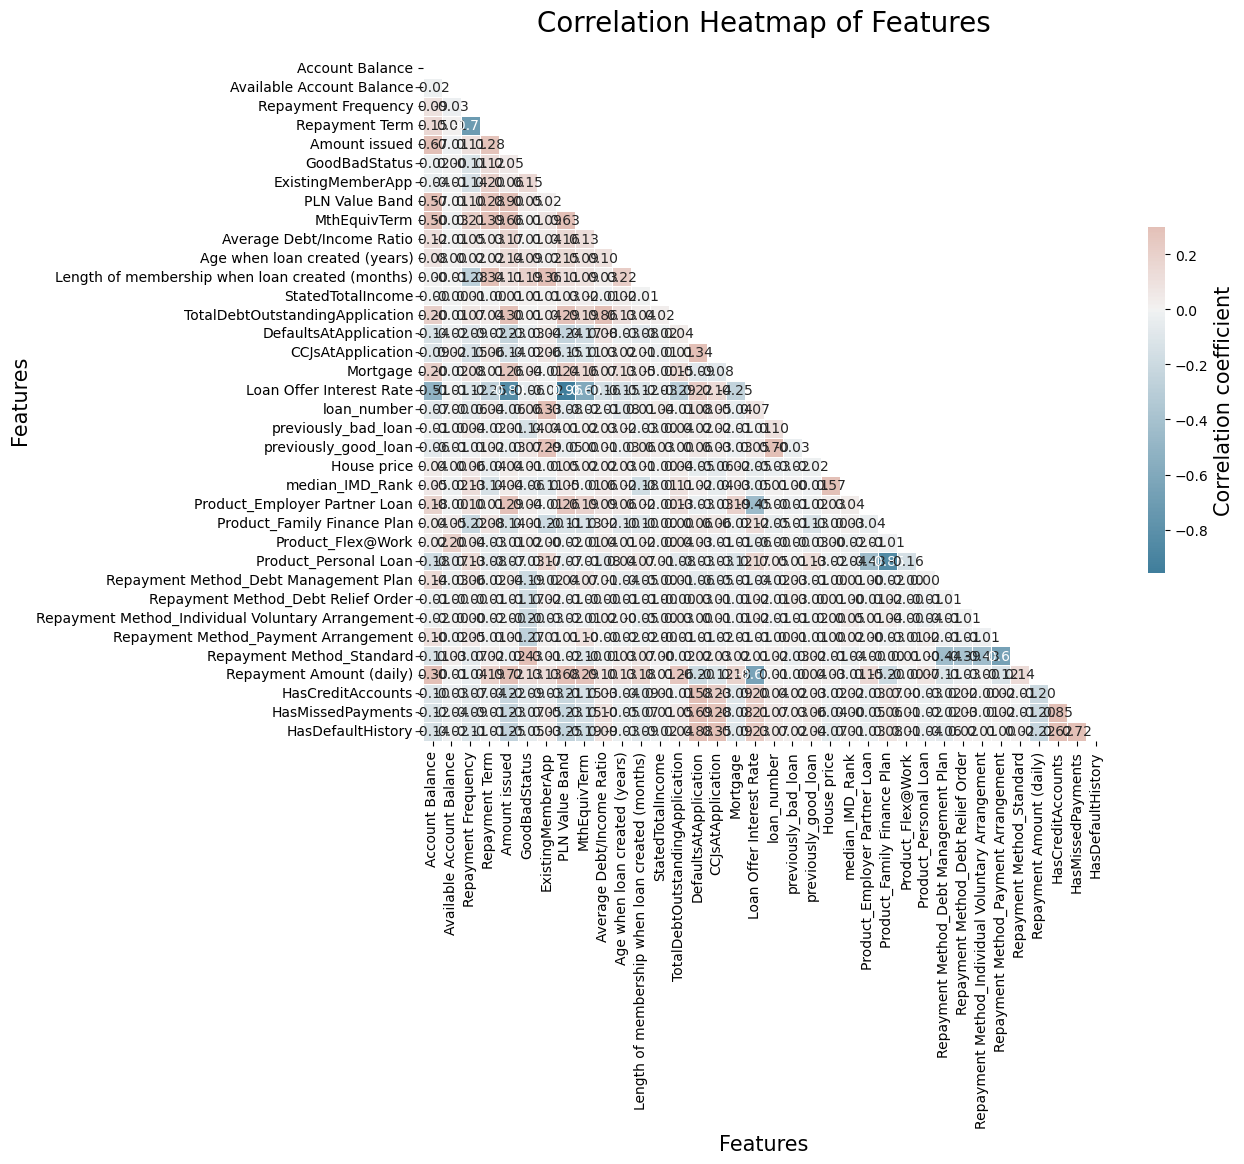

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr = data_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

# Rotate the x and y labels
# plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add title and adjust distance
plt.title('Correlation Heatmap of Features', fontsize=20, pad=20)

# Add labels to the x and y axes
plt.xlabel('Features', fontsize=15)
plt.ylabel('Features', fontsize=15)

# Add a colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label('Correlation coefficient', fontsize=15)

plt.show()

In [182]:
# Output correlation between y and other features
print(corr['GoodBadStatus'])

Account Balance                                     -0.023266
Available Account Balance                            0.001565
Repayment Frequency                                 -0.114620
Repayment Term                                       0.122797
Amount issued                                        0.050392
GoodBadStatus                                        1.000000
ExistingMemberApp                                    0.150510
PLN Value Band                                       0.050975
MthEquivTerm                                         0.005442
Average Debt/Income Ratio                            0.005710
Age when loan created (years)                        0.087650
Length of membership when loan created (months)      0.192837
StatedTotalIncome                                    0.007164
TotalDebtOutstandingApplication                      0.006626
DefaultsAtApplication                               -0.033880
CCJsAtApplication                                   -0.017332
Mortgage

In [183]:
# Find the top ten pairs of features with the highest correlation
corr_pairs = corr.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort", ascending=False)

# Remove duplicate pairs and self-correlation
no_duplicate_pairs = sorted_pairs.drop_duplicates()
strong_pairs = no_duplicate_pairs[no_duplicate_pairs != 1]

print("Top ten pairs of features with the highest correlation:")
print(strong_pairs.head(20))

Top ten pairs of features with the highest correlation:
PLN Value Band                   Amount issued                                      0.897631
HasDefaultHistory                DefaultsAtApplication                              0.875058
TotalDebtOutstandingApplication  Average Debt/Income Ratio                          0.864795
HasCreditAccounts                HasMissedPayments                                  0.852123
HasDefaultHistory                HasMissedPayments                                  0.722789
Amount issued                    Repayment Amount (daily)                           0.722323
previously_good_loan             loan_number                                        0.698551
HasMissedPayments                DefaultsAtApplication                              0.687199
Repayment Amount (daily)         PLN Value Band                                     0.682517
Account Balance                  Amount issued                                      0.674735
MthEquivTerm  

In [184]:
print(strong_pairs.tail(20))

HasDefaultHistory                   Amount issued                                       -0.246924
Repayment Term                      Loan Offer Interest Rate                            -0.251418
PLN Value Band                      HasDefaultHistory                                   -0.252544
Loan Offer Interest Rate            Mortgage                                            -0.253070
GoodBadStatus                       Repayment Method_Payment Arrangement                -0.267829
Repayment Frequency                 Length of membership when loan created (months)     -0.283072
Loan Offer Interest Rate            TotalDebtOutstandingApplication                     -0.286236
Repayment Method_Debt Relief Order  Repayment Method_Standard                           -0.386537
Repayment Method_Standard           Repayment Method_Individual Voluntary Arrangement   -0.432499
Product_Employer Partner Loan       Product_Personal Loan                               -0.432624
Repayment Method_Sta

In [185]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Convert columns of boolean type to integer type
test_df = data_df.astype({col: 'int' for col in data_df.columns if data_df[col].dtype == 'bool'})
test_df = test_df.drop(columns=['GoodBadStatus'])
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = test_df.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(test_df.values, i) 
                          for i in range(len(test_df.columns))] 

print(vif_data)

                                              feature         VIF
0                                     Account Balance    2.328373
1                           Available Account Balance    1.051571
2                                 Repayment Frequency    5.290221
3                                      Repayment Term    5.849517
4                                       Amount issued   13.354524
5                                   ExistingMemberApp    5.342780
6                                      PLN Value Band   63.057511
7                                        MthEquivTerm    4.097480
8                           Average Debt/Income Ratio    4.352247
9                       Age when loan created (years)    1.116369
10    Length of membership when loan created (months)    1.434834
11                                  StatedTotalIncome    1.011985
12                    TotalDebtOutstandingApplication    4.754758
13                              DefaultsAtApplication   13.575345
14        

# Feature Selection

# Filter Methods

In [186]:
from sklearn.model_selection import train_test_split
# Split the training set and test set
y = data_df['GoodBadStatus']
X = data_df.drop('GoodBadStatus', axis=1)

def create_balanced_train_test(X, y, random_state=42):
    """
    Splits an imbalanced dataset into balanced training and test sets.
    First, it selects all instances of the minority class, then randomly samples an equal number of instances from the majority class.
    Finally, it randomly selects 20% of the data as the test set and the remaining as the training set.

    Parameters:
    X - Feature data
    y - Label data
    test_size - Proportion of the test set
    random_state - Random seed

    Returns:
    X_train_balanced - Balanced training set features
    X_test_balanced - Balanced test set features
    y_train_balanced - Balanced training set labels
    y_test_balanced - Balanced test set labels
    """

    # Select all instances of the minority class
    X_minority = X[y == 0]
    y_minority = y[y == 0]

    # Randomly sample an equal number of instances from the majority class
    X_majority = X[y == 1]
    y_majority = y[y == 1]

    # Select an equal number of majority class samples as the minority class
    X_majority_sampled, _, y_majority_sampled, _ = train_test_split(
        X_majority, y_majority, train_size=len(X_minority), random_state=random_state, stratify=None)

    # Merge minority and majority class samples
    X_balanced = pd.concat([X_minority, X_majority_sampled])
    y_balanced = pd.concat([y_minority, y_majority_sampled])

    return X_balanced, y_balanced

# Use the function to create balanced training and test sets
X, y = create_balanced_train_test(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [187]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7850


In [188]:
print(f'Number of featurese: {X_train.shape[1]}')

Number of featurese: 35


In [36]:
# Drop variables changeable during the course of the loan
# data_df = data_df.drop(columns = ['Account Balance', 'Available Account Balance', 'Repayment Term', 'Repayment Frequency'])

In [190]:
from sklearn.model_selection import train_test_split
# Split the training set and test set
y = data_df['GoodBadStatus']
X = data_df.drop('GoodBadStatus', axis=1)

def create_balanced_train_test(X, y, random_state=42):
    """
    Splits an imbalanced dataset into balanced training and test sets.
    First, it selects all instances of the minority class, then randomly samples an equal number of instances from the majority class.
    Finally, it randomly selects 20% of the data as the test set and the remaining as the training set.

    Parameters:
    X - Feature data
    y - Label data
    test_size - Proportion of the test set
    random_state - Random seed

    Returns:
    X_train_balanced - Balanced training set features
    X_test_balanced - Balanced test set features
    y_train_balanced - Balanced training set labels
    y_test_balanced - Balanced test set labels
    """

    # Select all instances of the minority class
    X_minority = X[y == 0]
    y_minority = y[y == 0]

    # Randomly sample an equal number of instances from the majority class
    X_majority = X[y == 1]
    y_majority = y[y == 1]

    # Select an equal number of majority class samples as the minority class
    X_majority_sampled, _, y_majority_sampled, _ = train_test_split(
        X_majority, y_majority, train_size=len(X_minority), random_state=random_state, stratify=None)

    # Merge minority and majority class samples
    X_balanced = pd.concat([X_minority, X_majority_sampled])
    y_balanced = pd.concat([y_minority, y_majority_sampled])

    return X_balanced, y_balanced

# Use the function to create balanced training and test sets
X, y = create_balanced_train_test(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [193]:
############## Information Gain ##################
from sklearn.feature_selection import mutual_info_classif


# Calculate mutual inofrmation (information gain) for each feature
mi = mutual_info_classif(X, y, discrete_features=True, random_state=42)
mi_df = pd.DataFrame({'Feature': X.columns, 'Information Gain': mi})
mi_df = mi_df.sort_values(by='Information Gain', ascending=False)

print("Information Gain of Each Feature")
print(mi_df)

Information Gain of Each Feature
                                              Feature  Information Gain
8                           Average Debt/Income Ratio          0.657219
12                    TotalDebtOutstandingApplication          0.612981
31                           Repayment Amount (daily)          0.592187
4                                       Amount issued          0.326370
0                                     Account Balance          0.284148
11                                  StatedTotalIncome          0.245616
20                                        House price          0.172540
21                                    median_IMD_Rank          0.164555
10    Length of membership when loan created (months)          0.118778
30                          Repayment Method_Standard          0.076690
7                                        MthEquivTerm          0.073947
3                                      Repayment Term          0.064344
1                           Ava

C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\Alex\an

In [194]:
############## Information Gain ##################
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import KFold

# Set up k-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Initialize array to accumulate information gain values
info_gain_values = np.zeros(X_train.shape[1])

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Calculate mutual information (information gain) for each feature
    mi = mutual_info_classif(X_train_cv, y_train_cv, random_state=42)

    # Accumulate the results
    info_gain_values += mi

# Average the information gain across folds
info_gain_values /= kf.get_n_splits()

# Create DataFrame to store the results
mi_df = pd.DataFrame({'Feature': X_train.columns, 'Information Gain': info_gain_values})
mi_df = mi_df.sort_values(by='Information Gain', ascending=False)

print("Information Gain of Each Feature")
print(mi_df)

Information Gain of Each Feature
                                              Feature  Information Gain
0                                     Account Balance          0.116230
30                          Repayment Method_Standard          0.077150
10    Length of membership when loan created (months)          0.054855
21                                    median_IMD_Rank          0.032069
31                           Repayment Amount (daily)          0.027367
20                                        House price          0.025430
29               Repayment Method_Payment Arrangement          0.021689
4                                       Amount issued          0.019956
2                                 Repayment Frequency          0.018982
1                           Available Account Balance          0.018858
18                                previously_bad_loan          0.018765
28  Repayment Method_Individual Voluntary Arrangement          0.017299
3                              

In [195]:
# Select the top k features based on Information Gain
k = 10
top_features = mi_df['Feature'].head(k)

print(f"\nTop {k} important variables:")
print(top_features)


Top 10 important variables:
0                                     Account Balance
30                          Repayment Method_Standard
10    Length of membership when loan created (months)
21                                    median_IMD_Rank
31                           Repayment Amount (daily)
20                                        House price
29               Repayment Method_Payment Arrangement
4                                       Amount issued
2                                 Repayment Frequency
1                           Available Account Balance
Name: Feature, dtype: object


# Logistic Regression

In [196]:
# 1. Logistic regression (L2 regularisation)

from sklearn.linear_model import LogisticRegression

# Fit logistic regression
log_reg = LogisticRegression( max_iter=1000, random_state = 42)
log_reg.fit(X_train, y_train)

# Get coefficients
log_reg_coefficients = log_reg.coef_[0]  # Coefficients are in a 2D array for LogisticRegression

# Associate each coefficient with its corresponding variable name
coefficients_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg_coefficients
})

# Display the coefficients for each feature
print("Coefficients for Logistic Regression:\n", coefficients_df)

Coefficients for Logistic Regression:
                                               Feature  Coefficient
0                                     Account Balance    -0.000146
1                           Available Account Balance    -0.014801
2                                 Repayment Frequency     0.161431
3                                      Repayment Term     0.432514
4                                       Amount issued     0.100555
5                                   ExistingMemberApp     0.357469
6                                      PLN Value Band    -0.079358
7                                        MthEquivTerm    -0.233127
8                           Average Debt/Income Ratio     0.236036
9                       Age when loan created (years)     0.136004
10    Length of membership when loan created (months)     0.527339
11                                  StatedTotalIncome     0.027831
12                    TotalDebtOutstandingApplication    -0.170170
13                     

In [197]:
# Calculate feature importance based on coefficients
feature_importance = abs(log_reg.coef_[0])

# Display feature importance
import pandas as pd
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
print("Feature Importance:\n", feature_importance_df.sort_values(by="Importance", ascending=False))

Feature Importance:
                                               Feature  Importance
30                          Repayment Method_Standard    2.899921
18                                previously_bad_loan    1.998227
28  Repayment Method_Individual Voluntary Arrangement    0.943648
27                 Repayment Method_Debt Relief Order    0.732615
26              Repayment Method_Debt Management Plan    0.710932
32                                  HasCreditAccounts    0.679920
29               Repayment Method_Payment Arrangement    0.634925
10    Length of membership when loan created (months)    0.527339
34                                  HasDefaultHistory    0.526189
24                                  Product_Flex@Work    0.494408
3                                      Repayment Term    0.432514
13                              DefaultsAtApplication    0.395361
5                                   ExistingMemberApp    0.357469
25                              Product_Personal Loan  

In [216]:
# 2. Logistic Regression using L1 regularisation
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Define the logistic regression model with L1 penalty
model = LogisticRegression(penalty='l1', solver='saga', max_iter=1000, random_state=42, dual=False)

# Parameter distribution: C values from 0.0001 to 100 on a log scale
param_distributions = {'C': loguniform(1e-4, 1e2)}

# Setup RandomizedSearchCV with 100 iterations and 5-fold cross-validation
random_search = RandomizedSearchCV(model, param_distributions, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Get the best C value
best_c = random_search.best_params_['C']
print("Optimal C found: {:.4f}".format(best_c))

# Initialize Logistic Regression with the best C value found
best_log_reg = LogisticRegression(penalty='l1', C=best_c, solver='saga', max_iter=1000, dual=False, random_state=42)
best_log_reg.fit(X_train, y_train)

# Coefficients where some might be set to zero
coefficients = np.concatenate(([best_log_reg.intercept_[0]], best_log_reg.coef_[0]))

# Add intercept to the feature names
feature_names = ['Intercept'] + X_train.columns.tolist()

# Create a DataFrame for easier viewing
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Filter out features with zero coefficients
selected_features_logi = coef_df[coef_df['Coefficient'] != 0].reset_index(drop=True)

# Display selected features and their coefficients
print("Selected Features and Coefficients:\n", selected_features_logi)

# Sort features by the absolute value of their coefficients for importance
selected_features_logi['Absolute Coefficient'] = selected_features_logi['Coefficient'].abs()
sorted_features_logi = selected_features_logi.sort_values(by='Absolute Coefficient', ascending=False)
print("\nFeature Importance:\n", sorted_features_logi[['Feature', 'Absolute Coefficient']])


C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

Optimal C found: 0.9444
Selected Features and Coefficients:
                                             Feature  Coefficient
0                                         Intercept    -3.003280
1                         Available Account Balance    -0.014901
2                               Repayment Frequency     0.091109
3                                    Repayment Term     0.344781
4                                     Amount issued     0.048855
5                                 ExistingMemberApp     0.361794
6                                      MthEquivTerm    -0.159807
7                         Average Debt/Income Ratio     0.194838
8                     Age when loan created (years)     0.135777
9   Length of membership when loan created (months)     0.537001
10                  TotalDebtOutstandingApplication    -0.116744
11                            DefaultsAtApplication     0.306965
12                                CCJsAtApplication    -0.017961
13                         Lo

In [217]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each feature
X_train_with_intercept = sm.add_constant(X_train)
vif = pd.DataFrame()
vif["Feature"] = X_train_with_intercept.columns
vif["VIF"] = [variance_inflation_factor(X_train_with_intercept.values, i) for i in range(X_train_with_intercept.shape[1])]


# Identify variables with high VIF values
high_vif = vif_data[vif_data["VIF"] > 10]  # VIF threshold
print("Features with high VIF:")
print(high_vif)

Features with high VIF:
                        feature         VIF
4                 Amount issued   13.354524
6                PLN Value Band   63.057511
13        DefaultsAtApplication   13.575345
16     Loan Offer Interest Rate   52.023421
23  Product_Family Finance Plan   27.352699
25        Product_Personal Loan  322.483908
30    Repayment Method_Standard  346.365631
32            HasCreditAccounts   19.599223
33            HasMissedPayments   20.244929
34            HasDefaultHistory   12.838038


C:\Users\Alex\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\Alex\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [221]:
from scipy.stats import norm
from tabulate import tabulate

# Predicted probabilities
pred_probs = best_log_reg.predict_proba(X_train)[:, 1]
# Variance matrix
V = np.diag(pred_probs * (1 - pred_probs))
# Design matrix with intercept
X_train_with_intercept = sm.add_constant(X_train)
# Hessian matrix
Hessian = np.dot(np.dot(X_train_with_intercept.T, V), X_train_with_intercept)
# Covariance matrix
cov_matrix = np.linalg.pinv(Hessian)
# Standard errors
standard_errors = np.sqrt(np.diag(cov_matrix))

# Ensure standard_errors array matches the length of coefficients
if len(standard_errors) != len(coefficients):
    raise ValueError("Mismatch in length of standard errors and coefficients")

# Z-scores and p-values
z_scores = coefficients / standard_errors
p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

# Confidence intervals
conf_intervals = np.array([coefficients - 1.96 * standard_errors, coefficients + 1.96 * standard_errors]).T

# Create a DataFrame for the regression table
regression_table = pd.DataFrame({
    'Feature': ['Intercept'] + list(X_train.columns),
    'Coefficient': coefficients,
    'Std. Error': standard_errors,
    'z-score': z_scores,
    'p-value': p_values,
    'CI Lower 95%': conf_intervals[:, 0],
    'CI Upper 95%': conf_intervals[:, 1]
})

# Formatting the table using tabulate
formatted_table = tabulate(
    regression_table, 
    headers='keys', 
    tablefmt='latex', 
    floatfmt=".4f"
)

print("\nRegression Table:\n")
print(formatted_table)



Regression Table:

\begin{tabular}{rlrrrrrr}
\hline
    & Feature                                           &   Coefficient &   Std. Error &   z-score &   p-value &   CI Lower 95\% &   CI Upper 95\% \\
\hline
  0 & Intercept                                         &       -3.0033 &       1.5954 &   -1.8824 &    0.0598 &        -6.1303 &         0.1238 \\
  1 & Account Balance                                   &        0.0000 &       0.1299 &    0.0000 &    1.0000 &        -0.2547 &         0.2547 \\
  2 & Available Account Balance                         &       -0.0149 &       0.0653 &   -0.2283 &    0.8194 &        -0.1428 &         0.1130 \\
  3 & Repayment Frequency                               &        0.0911 &       0.1748 &    0.5212 &    0.6023 &        -0.2515 &         0.4338 \\
  4 & Repayment Term                                    &        0.3448 &       0.2201 &    1.5668 &    0.1172 &        -0.0865 &         0.7761 \\
  5 & Amount issued                               

In [286]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Filter X_train and X_test for selected features only
X_train_selected_logi = X_train[selected_features_logi['Feature']]
X_test_selected_logi = X_test[selected_features_logi['Feature']]

# Initialize the RandomForest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_selected_logi, y_train)


RandomForestClassifier(random_state=42)

In [287]:
# Predicting the Test set results for Logit Regression
y_pred = rf.predict(X_test_selected_logi)
y_prob = rf.predict_proba(X_test_selected_logi)[:, 1]  # probabilities for the positive class

# Calculate different performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# Calculate specificity from the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

# Print the performance metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'AUC: {auc:.4f}')
print(f'Specificity: {specificity:.4f}')


Accuracy: 0.7101
Precision: 0.7192
Recall: 0.6863
F1 Score: 0.7023
AUC: 0.7828
Specificity: 0.7338


# Filter, Embedded, and Wrapper Methods:

In [200]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, ElasticNetCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# 1. ANOVA F-value
best_k = 0
best_score = 0

for k in range(1, X_train.shape[1] + 1):
    selector_f_classif = SelectKBest(f_classif, k=k)
    X_new = selector_f_classif.fit_transform(X_train, y_train)
    score = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X_new, y_train, cv=5).mean()
    if score > best_score:
        best_score = score
        best_k = k

print(f'Optimal number of features for ANOVA F-value: {best_k}')
selector_f_classif = SelectKBest(f_classif, k=best_k)
X_train_anova = selector_f_classif.fit_transform(X_train, y_train)
X_test_anova = selector_f_classif.transform(X_test)

Optimal number of features for ANOVA F-value: 26


In [201]:
# 2. Recursive Feature Elimination (RFE)
best_n_features = 0
best_score = 0

for n in range(1, X_train.shape[1] + 1):
    rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=n, step=1)
    X_new = rfe_selector.fit_transform(X_train, y_train)
    score = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42), X_new, y_train, cv=5).mean()
    if score > best_score:
        best_score = score
        best_n_features = n

print(f'Optimal number of features for RFE: {best_n_features}')
rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=42), n_features_to_select=best_n_features, step=1)
X_train_rfe = rfe_selector.fit_transform(X_train, y_train)
X_test_rfe = rfe_selector.transform(X_test)

Optimal number of features for RFE: 34


In [202]:
# 3. Tree-based feature selection with RandomForestClassifier
tree_clf = RandomForestClassifier(n_estimators=100, random_state=42)
tree_clf.fit(X_train, y_train)
model_tree = SelectFromModel(tree_clf, prefit=True)
X_train_tree = model_tree.transform(X_train)
X_test_tree = model_tree.transform(X_test)

C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [203]:
##### Lasso is supposed to predict a continuous target variable. Since we do logistic with an L1 penalty (designed for a classification task), 
##### do we skip lasso here?

# 4. Lasso 

from sklearn.linear_model import Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# 1. Setup the Lasso with cross-validation to find the best alpha value
lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

# 2. Get the best alpha value
best_alpha = lasso_cv.alpha_
print("Optimal alpha found: {:.4f}".format(best_alpha))

# 3. Initialize Lasso with the best alpha value found
lasso = Lasso(alpha=best_alpha, random_state=42)
lasso.fit(X_train, y_train)

# 4. Perform feature selection
model_lasso = SelectFromModel(lasso, prefit=True)
X_train_lasso = model_lasso.transform(X_train)
X_test_lasso = model_lasso.transform(X_test)

Optimal alpha found: 0.0009


C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [204]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.stats import loguniform

# 5. LinearSVC (L1 based)

# Setup the LinearSVC with RandomizedSearchCV
model = LinearSVC(penalty="l1", dual=False, random_state=42)
param_distributions = {'C': loguniform(1e-4, 1e2)}  # C values from 0.0001 to 100 on a log scale

random_search = RandomizedSearchCV(model, param_distributions, n_iter=100, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Get the best C value
best_c_lsvc = random_search.best_params_['C']
print("Optimal C found: {:.4f}".format(best_c_lsvc))

# Initialize LinearSVC with the best C value found
lsvc = LinearSVC(C=best_c_lsvc, penalty="l1", dual=False, random_state=42)
lsvc.fit(X_train, y_train)

# Perform feature selection
model_lsvc = SelectFromModel(lsvc, prefit=True)
X_train_lsvc = model_lsvc.transform(X_train)
X_test_lsvc = model_lsvc.transform(X_test)

C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

Optimal C found: 0.3908


C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [205]:
# 6. Gradient Boosting feature selection
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(X_train, y_train)
model_gb = SelectFromModel(gb_clf, prefit=True)
X_train_gb = model_gb.transform(X_train)
X_test_gb = model_gb.transform(X_test)

C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [206]:
# 7. Elastic Net feature selection
enet = ElasticNetCV(cv=5, random_state=42)
enet.fit(X_train, y_train)
model_enet = SelectFromModel(enet, prefit=True)
X_train_enet = model_enet.transform(X_train)
X_test_enet = model_enet.transform(X_test)

C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\Alex\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [207]:
# Print the number of selected features for each method
print("Original number of features:", X_train.shape[1])
print("Features selected by ANOVA F-value:", X_train_anova.shape[1])
print("Features selected by RFE:", X_train_rfe.shape[1])
print("Features selected by Random Forest:", X_train_tree.shape[1])
print("Features selected by Lasso:", X_train_lasso.shape[1])
print("Features selected by Linear SVC:", X_train_lsvc.shape[1])
print("Features selected by Gradient Boosting method:", X_train_gb.shape[1])
print("Features selected by Elastic Net method:", X_train_enet.shape[1])

Original number of features: 35
Features selected by ANOVA F-value: 26
Features selected by RFE: 34
Features selected by Random Forest: 13
Features selected by Lasso: 24
Features selected by Linear SVC: 26
Features selected by Gradient Boosting method: 6
Features selected by Elastic Net method: 9


In [210]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, ElasticNetCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

random_seed = 42

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)


methods = ['RFE', 'Random Forest', 'Lasso', 'Linear SVC', 'Gradient Boosting', 'Elastic Net']
X_train_sets = [X_train_rfe, X_train_tree, X_train_lasso, X_train_lsvc, X_train_gb, X_train_enet]
X_test_sets = [X_test_rfe, X_test_tree, X_test_lasso, X_test_lsvc, X_test_gb, X_test_enet]

results = []

# Ensure consistency in the shape of y_test and each X_test_fs
# assert len(y_test) == X_test_scaled.shape[0], "Mismatch in test set sizes"

for method, X_train_fs, X_test_fs in zip(methods, X_train_sets, X_test_sets):
    assert X_test_fs.shape[0] == len(y_test), f"Mismatch in test set size for method {method}"
    
    clf = RandomForestClassifier(n_estimators=100, random_state=random_seed)
    clf.fit(X_train_fs, y_train)
    y_pred = clf.predict(X_test_fs)
    y_prob = clf.predict_proba(X_test_fs)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    results.append((method, accuracy, precision, recall, f1, auc, specificity))

# Create a DataFrame for the results
results_df = pd.DataFrame(results, columns=['Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Specificity'])

# Display the results
print(results_df)


              Method  Accuracy  Precision    Recall  F1 Score       AUC  \
0                RFE  0.788274   0.797297  0.771242  0.784053  0.863636   
1      Random Forest  0.755700   0.767123  0.732026  0.749164  0.838554   
2              Lasso  0.781759   0.794521  0.758170  0.775920  0.862236   
3         Linear SVC  0.700326   0.696774  0.705882  0.701299  0.773088   
4  Gradient Boosting  0.732899   0.744828  0.705882  0.724832  0.829386   
5        Elastic Net  0.635179   0.625767  0.666667  0.645570  0.720546   

   Specificity  
0     0.805195  
1     0.779221  
2     0.805195  
3     0.694805  
4     0.759740  
5     0.603896  


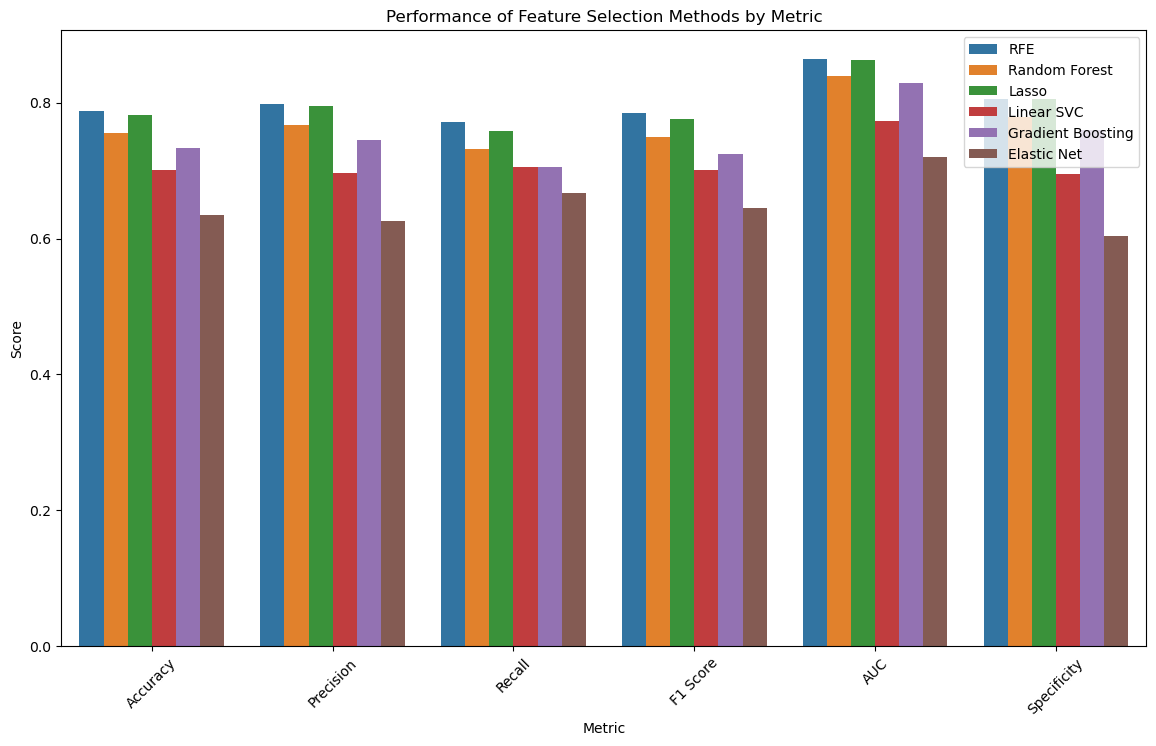

In [211]:
# Pivot the DataFrame to group by performance metrics
results_pivot = results_df.melt(id_vars='Method', var_name='Metric', value_name='Score')

# Plotting the results grouped by performance metrics
plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Method', data=results_pivot)
plt.title('Performance of Feature Selection Methods by Metric')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='best')
plt.show()

In [212]:
# Calculate the number of selected features for each method

num_selected_features = {
    'ANOVA F-value': X_train_anova.shape[1],
    'RFE': X_train_rfe.shape[1],
    'Random Forest': X_train_tree.shape[1],
    'Lasso': X_train_lasso.shape[1],
    'Linear SVC': X_train_lsvc.shape[1],
    'Gradient Boosting': X_train_gb.shape[1],
    'Elastic Net': X_train_enet.shape[1],

}

# Print the number of selected features for each method
print("Number of selected features for each method:")
for method, num_features in num_selected_features.items():
    print(f"{method}: {num_features}")


Number of selected features for each method:
ANOVA F-value: 26
RFE: 34
Random Forest: 13
Lasso: 24
Linear SVC: 26
Gradient Boosting: 6
Elastic Net: 9


In [213]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Prepare lists to store performance metrics
num_features = []
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
auc_list = []


# Function to evaluate model performance
def evaluate_model(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    return accuracy, precision, recall, f1, auc


# Iteratively train and evaluate model
for i in range(1, len(mi_df) + 1):
    selected_features_ig = mi_df['Feature'].iloc[:i]
    X_train_subset = X_train[selected_features_ig]
    X_test_subset = X_test[selected_features_ig]
    
    accuracy, precision, recall, f1, auc = evaluate_model(X_train_subset, X_test_subset, y_train, y_test)
    
    num_features.append(i)
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    auc_list.append(auc)

# Finding optimal number of features for each performance metric
optimal_features = {
    'Accuracy': num_features[accuracy_list.index(max(accuracy_list))],
    'Precision': num_features[precision_list.index(max(precision_list))],
    'Recall': num_features[recall_list.index(max(recall_list))],
    'F1 Score': num_features[f1_list.index(max(f1_list))],
    'AUC': num_features[auc_list.index(max(auc_list))]
}

# Print the optimal number of variables for each performance metric along with their values
print("Optimal number of variables for each performance metric and their values (information gain):")
for metric, num in optimal_features.items():
    if metric == 'Accuracy':
        value = accuracy_list[num - 1]
    elif metric == 'Precision':
        value = precision_list[num - 1]
    elif metric == 'Recall':
        value = recall_list[num - 1]
    elif metric == 'F1 Score':
        value = f1_list[num - 1]
    elif metric == 'AUC':
        value = auc_list[num - 1]
        
    print(f"{metric}: {num} variables, Value: {value:.4f}")


Optimal number of variables for each performance metric and their values (information gain):
Accuracy: 20 variables, Value: 0.7948
Precision: 2 variables, Value: 0.8228
Recall: 23 variables, Value: 0.7843
F1 Score: 20 variables, Value: 0.7907
AUC: 27 variables, Value: 0.8630


In [222]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.linear_model import LogisticRegression, ElasticNetCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to evaluate model performance
def evaluate_model(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    return accuracy, precision, recall, f1, auc, specificity

# Evaluate the model before feature selection
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

method = 'Before Feature Selection'
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn + fp)

original_results = [(method, accuracy, precision, recall, f1, auc, specificity)]
original_results_df = pd.DataFrame(original_results, columns=['Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Specificity'])

# Select top 39 variables based on information gain
top_features_ig = mi_df['Feature'].iloc[:39]
X_train_top_ig = X_train[top_features_ig]
X_test_top_ig = X_test[top_features_ig]

# Evaluate the model with top 39 variables
accuracy_ig, precision_ig, recall_ig, f1_ig, auc_ig, specificity_ig = evaluate_model(X_train_top_ig, X_test_top_ig, y_train, y_test)

# Append the results for Information Gain
original_results.append(('Information Gain', accuracy_ig, precision_ig, recall_ig, f1_ig, auc_ig, specificity_ig))

# Evaluate the model with selected features based on Logistic(l1)
accuracy_logi, precision_logi, recall_logi, f1_logi, auc_logi, specificity_logi = evaluate_model(X_train_selected_logi, X_test_selected_logi, y_train, y_test)
                                                                                                 
# Append the results for Logistic(L1)
original_results.append(('Logistic(L1)', accuracy_logi, precision_logi, recall_logi, f1_logi, auc_logi, specificity_logi))
                                                                                                
# Feature selection results DataFrame
methods = ['ANOVA F-value', 'RFE', 'Lasso', 'Linear SVC', 'Gradient Boosting', 'Elastic Net']
X_train_sets = [X_train_anova, X_train_rfe, X_train_lasso, X_train_lsvc, X_train_gb, X_train_enet]
X_test_sets = [X_test_anova, X_test_rfe, X_test_lasso, X_test_lsvc, X_test_gb, X_test_enet]

results = []

for method, X_train_fs, X_test_fs in zip(methods, X_train_sets, X_test_sets):
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_fs, y_train)
    y_pred = clf.predict(X_test_fs)
    y_prob = clf.predict_proba(X_test_fs)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    
    results.append((method, accuracy, precision, recall, f1, auc, specificity))

# Create DataFrame to display results
results_df = pd.DataFrame(results, columns=['Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Specificity'])

# Combine original results with feature selection results
original_results_df = pd.DataFrame(original_results, columns=['Method', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Specificity'])
combined_results_df = pd.concat([original_results_df, results_df], ignore_index=True)

# Remove duplicate rows (if any)
combined_results_df = combined_results_df.drop_duplicates(subset=['Method'])

# Pivot the DataFrame to group by performance metrics
results_pivot = combined_results_df.melt(id_vars='Method', var_name='Metric', value_name='Score')

# Ensure the Score column is numeric
results_pivot['Score'] = pd.to_numeric(results_pivot['Score'], errors='coerce')

# Plotting the results grouped by performance metrics
plt.figure(figsize=(14, 8))
sns.barplot(x='Metric', y='Score', hue='Method', data=results_pivot)
plt.title('Performance Metrics of Feature Selection')
plt.ylabel('Score')
plt.ylim(0.4, 0.85)  # Set y-axis limits
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)  # Place the legend outside the plot

plt.savefig('metrics.png', bbox_inches='tight')
plt.show()


NameError: name 'X_train_selected_logi' is not defined

In [301]:
combined_results_df

,Method,Accuracy,Precision,Recall,F1 Score,AUC,Specificity
0,Before Feature Selection,0.713355,0.704403,0.732026,0.717949,0.770138,0.694805
1,Information Gain,0.723127,0.712500,0.745098,0.728435,0.774382,0.701299
2,Logistic(L1),0.710098,0.719178,0.686275,0.702341,0.782765,0.733766
3,ANOVA F-value,0.700326,0.696774,0.705882,0.701299,0.755539,0.694805
4,RFE,0.713355,0.704403,0.732026,0.717949,0.781258,0.694805
5,Lasso,0.690554,0.704225,0.653595,0.677966,0.789789,0.727273
6,Linear SVC,0.700326,0.699346,0.699346,0.699346,0.782977,0.701299
7,Gradient Boosting,0.687296,0.683871,0.692810,0.688312,0.752737,0.681818
8,Elastic Net,0.657980,0.684615,0.581699,0.628975,0.698285,0.733766


In [302]:
# Saving data_df as a CSV file
#csv_file_path = r"C:\Users\jee12\OneDrive\문서\0_UOB\Dissertation\Data\results_1.csv"  
#combined_results_df.to_csv(csv_file_path, index=False)

In [303]:
selected_features_anova = X_train.columns[selector_f_classif.get_support()]
print("Selected features by ANOVA F-value:", selected_features_anova)

selected_features_rfe = X_train.columns[rfe_selector.get_support()]
print("Selected features by RFE:", selected_features_rfe)

selected_features_tree = X_train.columns[model_tree.get_support()]
print("Selected features by Random Forest:", selected_features_tree)

selected_features_lasso = X_train.columns[model_lasso.get_support()]
print("Selected features by Lasso :", selected_features_lasso)

selected_features_lsvc = X_train.columns[model_lsvc.get_support()]
print("Selected features by Linear SVC:", selected_features_lsvc)

selected_features_gb = X_train.columns[model_gb.get_support()]
print("Selected features by Gradient Boosting method:", selected_features_gb)

selected_features_enet = X_train.columns[model_enet.get_support()]
print("Selected features by Elastic Net method:", selected_features_enet)

Selected features by ANOVA F-value: Index(['Amount issued', 'Banding', 'ExistingMemberApp', 'PLN Value Band',
       'Month issued', 'AmIDebtCon', 'Average Debt/Income Ratio',
       'Age when loan created (years)',
       'Length of membership when loan created (months)',
       'DefaultsAtApplication', 'Mortgage', 'Loan Offer Interest Rate',
       'loan_number', 'previously_bad_loan', 'previously_good_loan',
       'median_IMD_Rank', 'Product_Employer Partner Loan', 'Product_Flex@Work',
       'Product_Personal Loan', 'Product Code (Product) (Product)_EP1',
       'Product Code (Product) (Product)_FAW',
       'Product Code (Product) (Product)_PLN1',
       'Repayment Method_Debt Management Plan',
       'Repayment Method_Debt Relief Order',
       'Repayment Method_Individual Voluntary Arrangement',
       'Repayment Method_Payment Arrangement', 'Repayment Method_Standard',
       'Repayment Amount (daily)', 'HasCreditAccounts', 'HasMissedPayments',
       'HasDefaultHistory'],
   

In [304]:
# Select the top 39 features based on Information Gain
k = 39
selected_features_ig = mi_df['Feature'].head(k)

print("Selected features by Information Gain:")
print(selected_features_ig)

Selected features by Information Gain:
35                            Repayment Method_Standard
18                                          House price
8       Length of membership when loan created (months)
19                                      median_IMD_Rank
36                             Repayment Amount (daily)
34                 Repayment Method_Payment Arrangement
11                                DefaultsAtApplication
31                Repayment Method_Debt Management Plan
29                Product Code (Product) (Product)_PLN1
25                Product Code (Product) (Product)_ADV1
24                                Product_Personal Loan
7                         Age when loan created (years)
12                                    CCJsAtApplication
37                                    HasCreditAccounts
39                                    HasDefaultHistory
1                                               Banding
2                                     ExistingMemberApp
16       

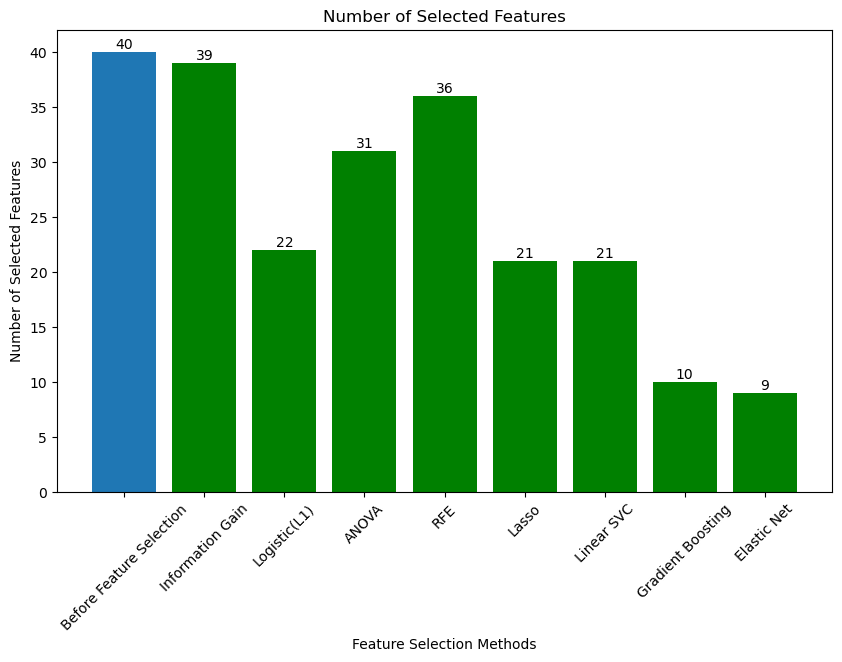

In [307]:
import matplotlib.pyplot as plt

# Count the number of selected features by each method
counts = {
    'Before Feature Selection' : X_train.shape[1],
    'Information Gain': len(selected_features_ig),
    'Logistic(L1)': len(selected_features_logi),
    'ANOVA': len(selected_features_anova),
    'RFE': len(selected_features_rfe),
    'Lasso': len(selected_features_lasso), 
    'Linear SVC': len(selected_features_lsvc),
    'Gradient Boosting': len(selected_features_gb),
    'Elastic Net': len(selected_features_enet)
}

# Prepare data for plotting
methods = list(counts.keys())
features_count = list(counts.values())

# Create the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, features_count, color=['tab:blue' if method == 'Before Feature Selection' else 'green' for method in methods])

# Add numbers on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval), va='bottom', ha='center')

plt.xlabel('Feature Selection Methods')
plt.ylabel('Number of Selected Features')
plt.title('Number of Selected Features')
plt.xticks(rotation=45)  # Rotates the labels on x-axis to avoid overlap

# Save the plot to a file
plt.savefig('featureNum.png', bbox_inches='tight')
plt.show()

